# Name: Dulanjana Perera (2059757)
# Course: CSC 578 / Final Project

## Loading libraries

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import csv
from google.colab import drive
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The Traffic Voolume dataset

This dataset includes 9 features including hourly traffic volume at Minnasota I-94

In [2]:
csv_path = tf.keras.utils.get_file(
    origin='https://reed.cs.depaul.edu/peterh/Essays/Metro_Interstate_reduced.csv',
    fname='Metro_Interstate_reduced.csv',
    cache_dir='/content', cache_subdir='sample_data')

Load the CSV file into a pandas dataframe and extract the time column

In [3]:
raw_df = pd.read_csv(csv_path)
date_time = pd.to_datetime(raw_df.pop('date_time'), format='%Y-%m-%d %H:%M:%S')

Checking the dataset variables

In [4]:
raw_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


## Data exploration

examine the type of data, their distribution and possible outliers

Full statistical description gives general idea of data type and range

In [5]:
raw_df.describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
holiday,40575,12,None,40522,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,40575.0,NaN,NaN,NaN,281.316763,13.816618,0.0,271.84,282.86,292.28,310.07
rain_1h,40575.0,NaN,NaN,NaN,0.318632,48.81264,0.0,0.0,0.0,0.0,9831.3
snow_1h,40575.0,NaN,NaN,NaN,0.000117,0.005676,0.0,0.0,0.0,0.0,0.51
clouds_all,40575.0,NaN,NaN,NaN,44.199162,38.683447,0.0,1.0,40.0,90.0,100.0
weather_main,40575,11,Clouds,15123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather_description,40575,35,sky is clear,11642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traffic_volume,40575.0,NaN,NaN,NaN,3290.650474,1984.772909,0.0,1248.5,3427.0,4952.0,7280.0


Abnormal value is norticed at rain_1h variable. It will be processed at the preprocessing stage

Data types for better understanding of variable types

In [6]:
raw_df.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
traffic_volume           int64
dtype: object

Few of the variables are categorical. Therefore, different examinations are needed to be conducted for categorical and numerical variables

Extract only the numerical values and plot the box plot for outlier detection

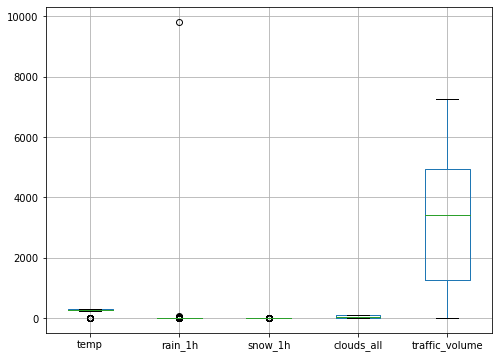

In [7]:
raw_df.loc[:, ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].boxplot(return_type='axes')

Clearly, an outlier is present. also normalization is needed due to the large variation of value ranges

remove the outlier at rain_1h and temp variables. because, 0 K is unnatural. Therefore set it to mean. (183K is the lowest in nature ever recorded in human history)

In [8]:
print("Maximum value before cleaning:\n", raw_df['rain_1h'].max())
raw_df['rain_1h'][raw_df['rain_1h']>8000] = raw_df['rain_1h'].mean()
print("Maximum value after correction:\n",raw_df['rain_1h'].max())
raw_df['temp'][raw_df['temp']<180] = raw_df['temp'].mean()

Maximum value before cleaning:
 9831.3
Maximum value after correction:
 55.63


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Check the range again to ensure that the oulier is remnoved

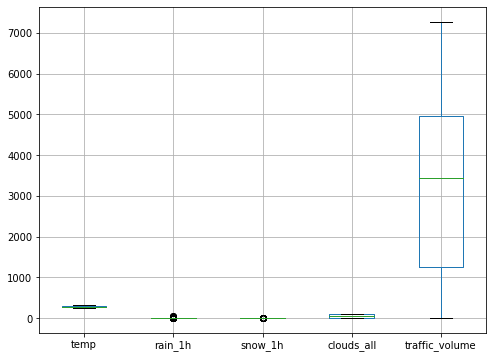

In [9]:
raw_df.loc[:, ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']].boxplot(return_type='axes')

Check the distribution of numeric variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f420e321210>,
      dtype=object)

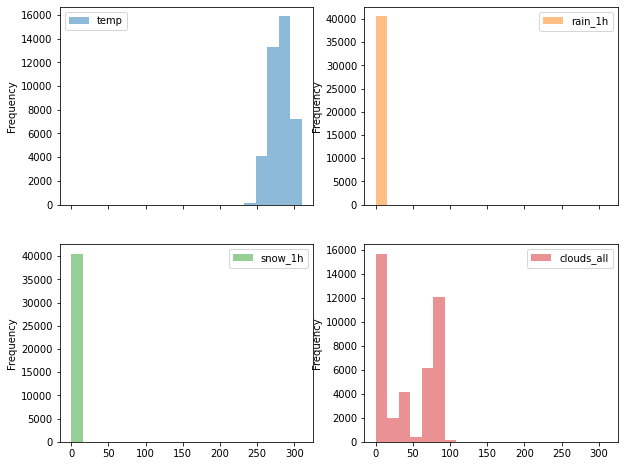

In [10]:
num_df = raw_df.loc[:, ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']]
num_df.loc[:, ['temp', 'rain_1h', 'snow_1h', 'clouds_all']].plot.hist(subplots=True, layout=(2,2),figsize=(10, 8), bins=20, alpha=0.5)

Values need to be normalized. highly skewed.

Visualize the behavior of selected variables over the time.

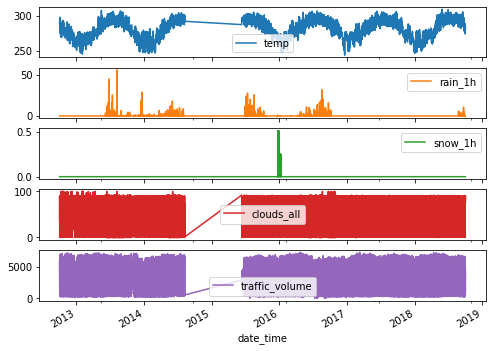

In [11]:
# From TF Tutorial.
plot_cols = ['temp', 'rain_1h', 'snow_1h', 'traffic_volume']
plot_features = num_df
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


The missing values at the middle is kept in order to maintain the required dataset size

Investigate the categorical variables

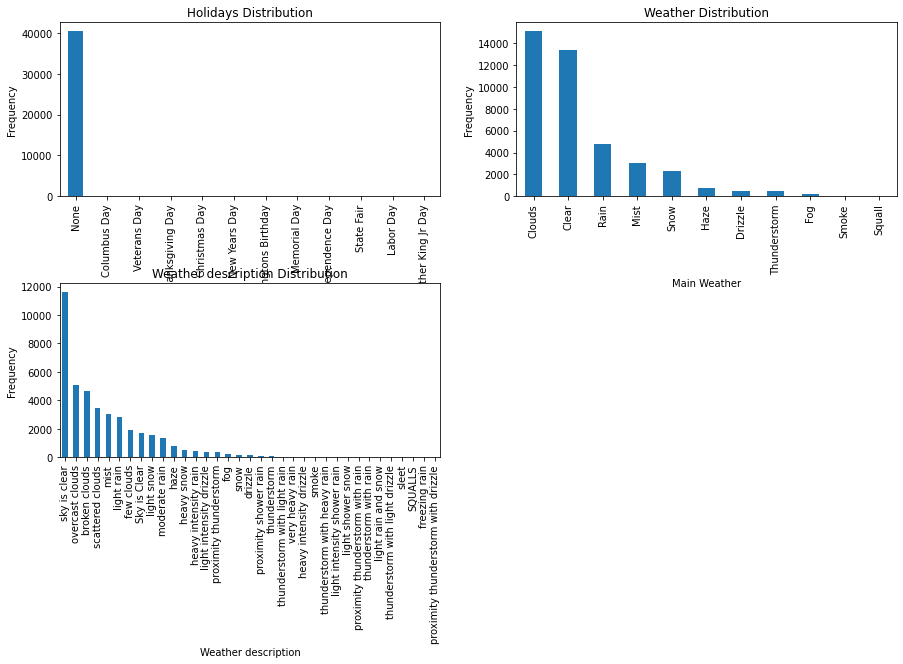

In [12]:
fig = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(2,2, hspace = 0.5)
ax1 = fig.add_subplot(gs[0,0])
ax1.set_xlabel('Holidays')
ax1.set_ylabel('Frequency')
ax1.set_title("Holidays Distribution")
raw_df["holiday"].value_counts().plot(kind='bar')

ax2 = fig.add_subplot(gs[0,1])
ax2.set_xlabel('Main Weather')
ax2.set_ylabel('Frequency')
ax2.set_title("Weather Distribution")
raw_df["weather_main"].value_counts().plot(kind='bar')

ax3 = fig.add_subplot(gs[1,0])
ax3.set_xlabel('Weather description')
ax3.set_ylabel('Frequency')
ax3.set_title("Weather description Distribution")
raw_df["weather_description"].value_counts().plot(kind='bar')


There are significant unbalance in categories. Initialy try the LSTM without categorical data.

### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Time

Convert the string datetime to seconds.

In [13]:
# From TF Tutorial.
timestamp_s = date_time.map(pd.Timestamp.timestamp) # sonvert to seconds

Convert the seconds to day and year as new features for the dataset

In [14]:
# From TF Tutorial.
day = 24*60*60
year = (365.2425)*day

raw_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
raw_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
raw_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
raw_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

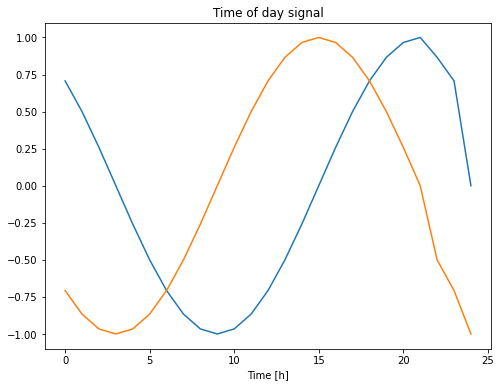

In [15]:
# From TF Tutorial.
plt.plot(np.array(raw_df['Day sin'])[:25])
plt.plot(np.array(raw_df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Fourier plot gives an idea of which time is more dominant for the traffic data. As suspected day is the dominant frequency.


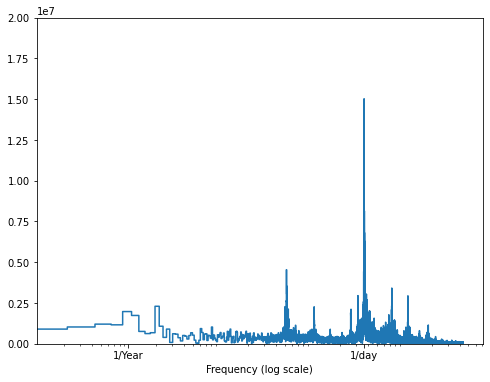

In [16]:
# From TF Tutorial.
fft = tf.signal.rfft(raw_df['traffic_volume'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(raw_df['traffic_volume'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 20000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

Data is splitted for given lengths. The training set is further splitted for validation which is approximately the 30% of total training data.

In [17]:
# extracted only the selected columns
df = raw_df.loc[:, ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'Day sin', 'traffic_volume']]
column_indices = {name: i for i, name in enumerate(df.columns)}

val = 0.3 # validation percentage from training set
train_df = df[0:int(35575*(1-val))]
val_df = df[int(35575*(1-val)):35575]
test_df = df[35575:]

num_features = df.shape[1]

### Normalize the data

Separate normalization leads to wrong pediction. therefore all the data is normalized according to the train data.

In [18]:
# From TF Tutorial.
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

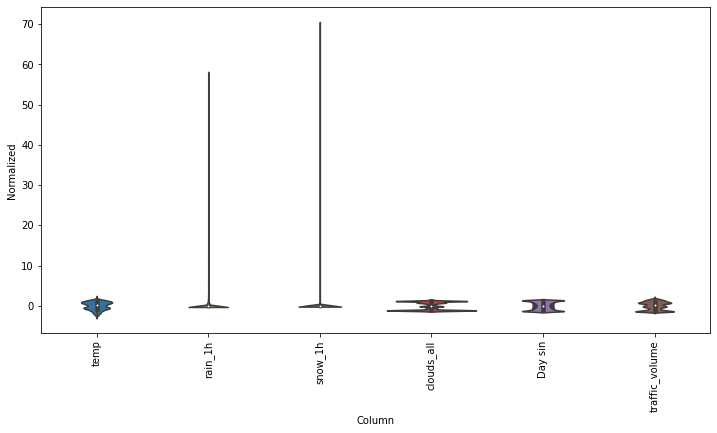

In [19]:
# From TF Tutorial.
df_std_ = (df - train_mean) / train_std
df_std = df_std_.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

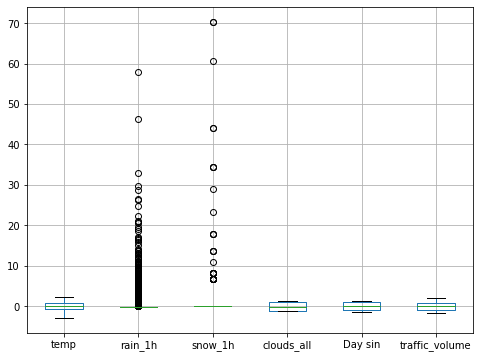

In [20]:
df_std_.boxplot(return_type='axes')

## Data windowing

Here I used tutorial function to generate datawindows

### 1. Indexes and offsets


In [21]:
# From TF Tutorial.
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # [DP] Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    if label_columns is not None: # [DP] if there is multiple column predictions
      # [DP] put the column names (in this case 'traffic_volume')
      # and the indices in a dictionary
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    # [DP] keep a dictionary of column details
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # [DP] keep the window parameters
    self.input_width = input_width
    self.label_width = label_width # [DP] in this exercise this is 1
    self.shift = shift # [DP] future prediction

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width) # [DP] create clice vector
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### 2. Split

Uses the generated indeces to split the data into seperate sets (inputs and labels)

In [22]:
# From TF Tutorial.
def split_window(self, features):
  inputs = features[:, self.input_slice, :] # extract variables
  labels = features[:, self.labels_slice, :] # extract lables. here only one
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # [TF]Slicing doesn't preserve static shape information, so set the shapes
  # [TF]manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [52]:
# From TF Tutorial.
# modified to match with our dataset
def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example # [DP] since not example, it uses train function
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')

    # [DP] plot original data
    plt.plot(self.input_indices, inputs[n, :,plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns: # [DP] get the label column index here it is None
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index # [DP] label is explicitly given here

    # [DP] if no label is given the just plot only the data (no predictions)
    # because no lebel to compare the predictions
    if label_col_index is None:
      continue

    # [DP] plot symbols on top of original data
    plt.scatter(self.label_indices, labels[n, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    
    if model is not None: # [DP] use the predicted values to plot
      predictions = model(inputs)
      # [DP] plot predictions
      plt.scatter(self.label_indices, predictions[n, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

### 4. Create `tf.data.Dataset`s

Create the datasets using the calculated indeces.

In [24]:
# From TF Tutorial.
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False, # make it False
      batch_size=batchsize,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [25]:
# From TF Tutorial.
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # [TF] No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # [TF} And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Generate data windows for baseline and RNN

In [26]:
batchsize = 32 # this is a global variable. It uses in the data generation and
               # used to change during the parameter tuning.
data_window = WindowGenerator(
    input_width=12, label_width=1, shift=3,
    label_columns=['traffic_volume'])
data_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [14]
Label column name(s): ['traffic_volume']

In [27]:
# from TF tutorial
for example_inputs, example_labels in data_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 12, 6)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Define a baseline model for comparision


In [28]:
# From TF Tutorial.
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index
  
  # outputs the given input value
  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Evaluate the model

In [29]:
# From TF Tutorial.
baseline = Baseline(label_index=column_indices['traffic_volume'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {} # [DP] use for the comparision
performance = {}
val_performance['Baseline'] = baseline.evaluate(data_window.val)
performance['Baseline'] = baseline.evaluate(data_window.test, verbose=0)

334/334 [==============================] - 2s 6ms/step - loss: 2.4140 - mean_absolute_error: 1.3282


Baseline does not give any good results. 

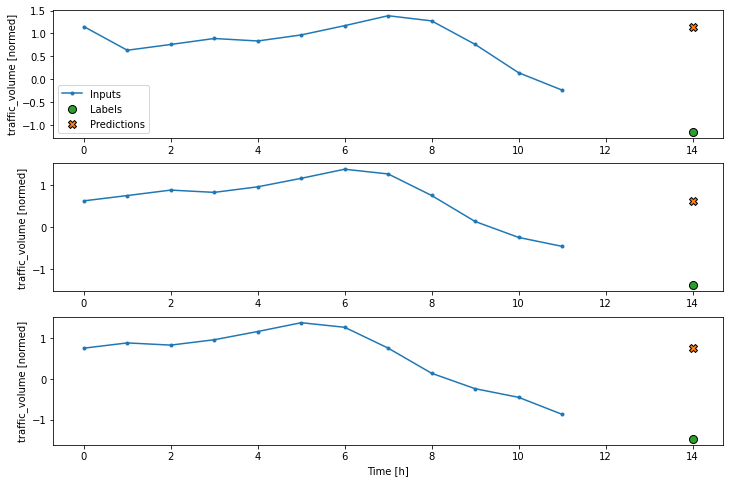

In [30]:
data_window.plot(baseline)

### Setup the compilation

In [31]:
# From TF Tutorial.
MAX_EPOCHS = 25

def compile_and_fit(model, window, patience=3):
  # [DP] define early stop which preserv the best model
  # the callback function check the validation loss and when it hit the bottom
  # and start to rise, function wait for 3 epochs and stop the training
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

 # [DP] this for statefulness analysis. The batch size should be same for each case.
  history = model.fit(window.train.take(2764), epochs=MAX_EPOCHS, 
                      validation_data=window.val.take(1184), 
                      callbacks=[early_stopping])
  # history = model.fit(window.train, epochs=MAX_EPOCHS, 
  #                     validation_data=window.val, 
  #                     callbacks=[early_stopping])
  return history

### Recurrent neural network


Model generation

In [32]:
def lstmLayers(n, l, stateful = False, d = 0.0):
  # [DP] batch_input_shape = (batchsize, 12, 6)
  # [DP] the function returns differen size of model with given parameters
  if l == 1:
    model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(n, return_sequences=False, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.Dense(units=1)
    ])
    return model
  elif l == 2:
    model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(n, return_sequences=True, recurrent_dropout=d, stateful=stateful, batch_input_shape = (batchsize, 12, 6)),
      tf.keras.layers.LSTM(n, return_sequences=False, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.Dense(units=1)
    ])
    return model 
  elif l == 3:
    model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(n, return_sequences=True, recurrent_dropout=d, stateful=stateful, batch_input_shape = (batchsize, 12, 6)),
      tf.keras.layers.LSTM(n, return_sequences=True, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.LSTM(n, return_sequences=False, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.Dense(units=1)
    ])
    return model
  elif l == 4:
    model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(n, return_sequences=True, recurrent_dropout=d, stateful=stateful, batch_input_shape = (batchsize, 12, 6)),
      tf.keras.layers.LSTM(n, return_sequences=True, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.LSTM(n, return_sequences=True, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.LSTM(n, return_sequences=False, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.Dense(units=1)
    ])
    return model
  elif l == 5:
    model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(n, return_sequences=True, recurrent_dropout=d, stateful=stateful, batch_input_shape = (batchsize, 12, 6)),
      tf.keras.layers.LSTM(n, return_sequences=True, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.LSTM(n, return_sequences=True, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.LSTM(n, return_sequences=True, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.LSTM(n, return_sequences=False, recurrent_dropout=d, stateful=stateful),
      tf.keras.layers.Dense(units=1)
    ])
    return model

### ***Best Model
create the model and train it

In [35]:
batchsize = 9
model = lstmLayers(64, 4, stateful = True, d = 0.0)
history = compile_and_fit(model, data_window, 3)

Epoch 1/25
2764/2764 [==============================] - 34s 11ms/step - loss: 0.3309 - mean_absolute_error: 0.4061 - val_loss: 0.1329 - val_mean_absolute_error: 0.2533
Epoch 2/25
2764/2764 [==============================] - 31s 11ms/step - loss: 0.1951 - mean_absolute_error: 0.2883 - val_loss: 0.0869 - val_mean_absolute_error: 0.2004
Epoch 3/25
2764/2764 [==============================] - 38s 14ms/step - loss: 0.1560 - mean_absolute_error: 0.2516 - val_loss: 0.0803 - val_mean_absolute_error: 0.1898
Epoch 4/25
2764/2764 [==============================] - 28s 10ms/step - loss: 0.1378 - mean_absolute_error: 0.2350 - val_loss: 0.0793 - val_mean_absolute_error: 0.1879
Epoch 5/25
2764/2764 [==============================] - 35s 13ms/step - loss: 0.1269 - mean_absolute_error: 0.2243 - val_loss: 0.0761 - val_mean_absolute_error: 0.1820
Epoch 6/25
2764/2764 [==============================] - 32s 12ms/step - loss: 0.1179 - mean_absolute_error: 0.2147 - val_loss: 0.0684 - val_mean_absolute_error:

In [36]:
val_performance['LSTM_best'] = model.evaluate(data_window.val.take(1184))
performance['LSTM_best'] = model.evaluate(data_window.test, verbose=0)

1184/1184 [==============================] - 6s 5ms/step - loss: 0.0487 - mean_absolute_error: 0.1402


Evaluate the testing data set

In [37]:
print(model.evaluate(data_window.test, verbose=0))

[0.034763697534799576, 0.12576602399349213]


Plot the model perfomacne during the training

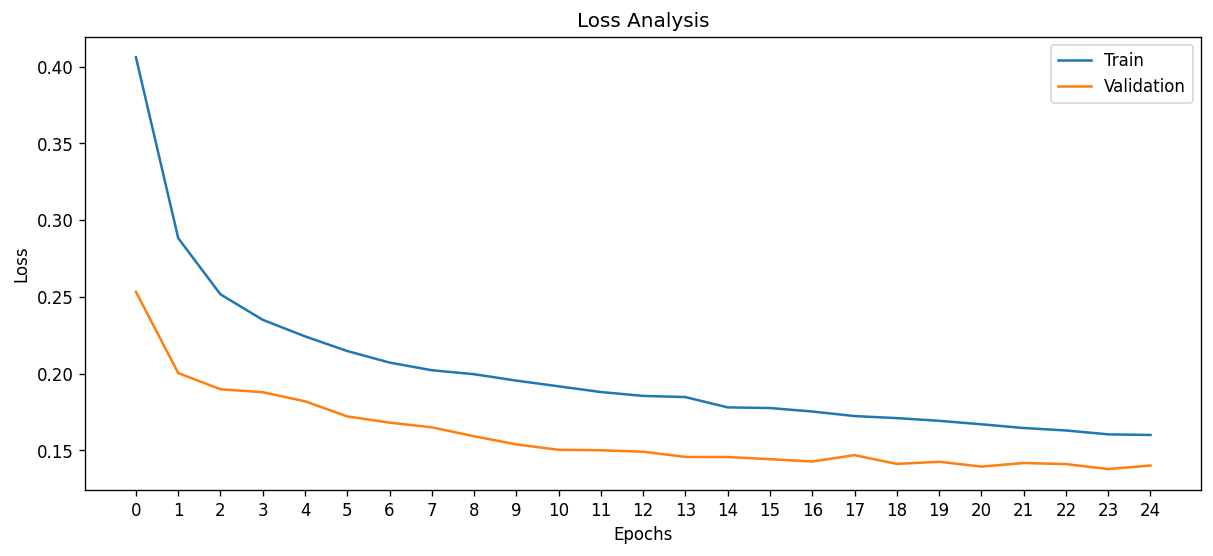

In [42]:
xticks = [str(x) for x in range(MAX_EPOCHS)] # x-axis stick labels
tr = np.array(history.history['mean_absolute_error'])
ts = np.array(history.history['val_mean_absolute_error'])
xaxis = np.arange(1, len(tr)+1, 1)
plt.figure(1, figsize=(12, 5), dpi=120)
plt.plot(xaxis, tr, xaxis, ts)
plt.xticks(xaxis, xticks)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Analysis")
plt.legend(("Train", "Validation"))

### second best model

In [43]:
batchsize = 9
model2 = lstmLayers(64, 2, stateful = True, d = 0.0)
history = compile_and_fit(model2, data_window, 3)

Epoch 1/25
2764/2764 [==============================] - 24s 8ms/step - loss: 0.2919 - mean_absolute_error: 0.3771 - val_loss: 0.1423 - val_mean_absolute_error: 0.2765
Epoch 2/25
2764/2764 [==============================] - 19s 7ms/step - loss: 0.1893 - mean_absolute_error: 0.2851 - val_loss: 0.0995 - val_mean_absolute_error: 0.2171
Epoch 3/25
2764/2764 [==============================] - 21s 8ms/step - loss: 0.1617 - mean_absolute_error: 0.2559 - val_loss: 0.0827 - val_mean_absolute_error: 0.1944
Epoch 4/25
2764/2764 [==============================] - 20s 7ms/step - loss: 0.1434 - mean_absolute_error: 0.2376 - val_loss: 0.0791 - val_mean_absolute_error: 0.1871
Epoch 5/25
2764/2764 [==============================] - 22s 8ms/step - loss: 0.1305 - mean_absolute_error: 0.2250 - val_loss: 0.0750 - val_mean_absolute_error: 0.1827
Epoch 6/25
2764/2764 [==============================] - 21s 8ms/step - loss: 0.1218 - mean_absolute_error: 0.2165 - val_loss: 0.0712 - val_mean_absolute_error: 0.177

In [44]:
val_performance['LSTM_secondBest'] = model2.evaluate(data_window.val.take(1184))
performance['LSTM_secondBest'] = model2.evaluate(data_window.test, verbose=0)

1184/1184 [==============================] - 5s 4ms/step - loss: 0.0504 - mean_absolute_error: 0.1456


### Performance

With this dataset typically each of the models does slightly better than the one before it:

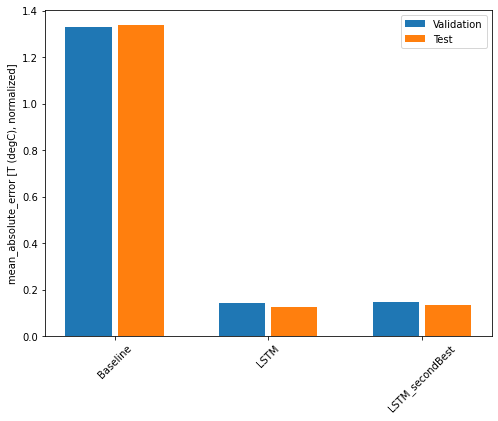

In [45]:
# From TF Tutorial.
# [DP] plot the performance of baseline and the best model
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [46]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 1.3362
LSTM        : 0.1258
LSTM_secondBest: 0.1322


values are not as same as mentioned in the report due to the random variable initialization.

## Prediction and save

Predict the values and save them in a csv file

In [47]:
pred = model.predict(data_window.test)
correct_pred = pred.flatten().flatten().tolist()

554/554 [==============================] - 4s 5ms/step


In [ ]:
# mount the driver
drive.mount("/content/drive") 

# header names
csv_header = ['id' , 'prediction']
with open('/content/drive/My Drive/CSC 578 - NN and DL/FinalProject/submission.csv', 'w', encoding='UTF8', newline='') as sub:
    writer = csv.writer(sub)
    writer.writerow(csv_header) # write the headers
    
    count = 0
    for i in range(35589,40575):
      temp_l = [i, correct_pred[count]*train_std[-1]+train_mean[-1]] # tsd of traffic
      writer.writerow(temp_l)
      count += 1